In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [2]:
folder = r"E:\file"
file1 = "Votes.csv"
path1 = os.path.join(folder, file1)
votes = pd.read_csv(path1, usecols=["PostId", "VoteTypeId", "CreationDate", "UserId", "BountyAmount"])

file2 = "Posts.csv"
path2 = os.path.join(folder, file2)
posts = pd.read_csv(path2)

file2 = "Users.csv"
path2 = os.path.join(folder, file2)
users = pd.read_csv(path2)
users = users[users["Reputation"] > 0].copy()

In [3]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577301 entries, 0 to 577300
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     577301 non-null  int64  
 1   PostTypeId             577301 non-null  int64  
 2   AcceptedAnswerId       99761 non-null   float64
 3   CreationDate           577301 non-null  object 
 4   Score                  577301 non-null  int64  
 5   ViewCount              234152 non-null  float64
 6   Body                   576958 non-null  object 
 7   OwnerUserId            556342 non-null  float64
 8   LastEditorUserId       283000 non-null  float64
 9   LastEditDate           293278 non-null  object 
 10  LastActivityDate       577301 non-null  object 
 11  Title                  234152 non-null  object 
 12  Tags                   234152 non-null  object 
 13  AnswerCount            234152 non-null  float64
 14  CommentCount           577301 non-nu

In [4]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357504 entries, 0 to 2357503
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   PostId        int64  
 1   VoteTypeId    int64  
 2   CreationDate  object 
 3   UserId        float64
 4   BountyAmount  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 89.9+ MB


In [5]:
users

,Id,Reputation,CreationDate,DisplayName,LastAccessDate,WebsiteUrl,Location,AboutMe,Views,UpVotes,DownVotes,AccountId
0,-1,1,2010-11-01T17:53:28.330,Community,2010-11-01T17:53:28.330,http://meta.stackexchange.com/,on the server farm,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",4642,0,0,-1.0
1,2,101,2010-11-01T19:19:09.697,Geoff Dalgas,2023-10-03T00:34:53.647,http://stackoverflow.com,"Corvallis, OR",<p>Dev #2 who helped create Stack Overflow cur...,108,5,0,2.0
2,3,101,2010-11-01T22:25:38.390,Jin,2019-08-30T05:08:29.010,http://www.8164.org,"Raleigh, NC",<p>I used to design stuff for Stack Exchange. ...,68,24,0,21721.0
3,4,6907,2010-11-01T23:01:40.147,Jonathan.,2023-07-24T00:16:54.763,http://jonathanb.co.uk,United Kingdom,<p>I'm a 25 year old Software engineer in Lond...,1354,45,3,64959.0
4,5,101,2010-11-02T03:56:21.077,Jason Punyon,2023-07-22T19:42:25.617,https://jasonpunyon.com,Restore the Data Dumps,<p>Chaotic Good w a splash of Data. Dad x2. St...,38,0,0,4188.0
...,...,...,...,...,...,...,...,...,...,...,...,...
319430,391197,1,2024-01-13T12:42:29.460,Dimitris Konstantinou,2024-03-22T08:36:03.323,NaN,NaN,NaN,1,0,0,30324834.0
319431,391198,1,2024-01-13T13:03:54.743,Shivangi Bhardwaj,2024-01-14T05:33:10.267,NaN,NaN,NaN,0,0,0,29328952.0
319432,391199,1,2024-01-13T13:32:34.223,Julie Carr,2024-01-13T14:04:06.480,NaN,NaN,NaN,0,0,0,30325036.0
319433,391200,1,2024-01-13T13:34:58.140,Wiener Küchen Küchenstudio,2024-01-13T13:34:58.140,https://wienerkuechen.at,Am Hauptplatz 7/2 2320 Schwechat,<p><strong>Phone</strong>: +43 660 495 05 81<...,0,0,0,30290164.0


In [6]:
posts = posts[posts["OwnerUserId"].notnull()]
posts["OwnerUserId"] = posts["OwnerUserId"].astype(int)
posts["CreationDate"] = pd.to_datetime(posts["CreationDate"], errors='coerce')

# 2. 创建 Month 列（按月对齐）
posts["Month"] = posts["CreationDate"].dt.to_period("M").dt.to_timestamp()

# === 2. 合并 votes + posts，获取 post 作者 + post 类型 ===
votes = votes.merge(posts, left_on="PostId", right_on="Id", how="left")
votes

,PostId,VoteTypeId,CreationDate_x,UserId,BountyAmount,Id,PostTypeId,AcceptedAnswerId,CreationDate_y,Score,...,AnswerCount,CommentCount,ContentLicense,ParentId,OwnerDisplayName,ClosedDate,LastEditorDisplayName,CommunityOwnedDate,FavoriteCount,Month
0,1,2,2010-11-02T00:00:00.000,NaN,NaN,1.0,1.0,5.0,2010-11-02 18:59:01.140,87.0,...,6.0,3.0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN,2010-11-01
1,1,2,2010-11-02T00:00:00.000,NaN,NaN,1.0,1.0,5.0,2010-11-02 18:59:01.140,87.0,...,6.0,3.0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN,2010-11-01
2,1,2,2010-11-02T00:00:00.000,NaN,NaN,1.0,1.0,5.0,2010-11-02 18:59:01.140,87.0,...,6.0,3.0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN,2010-11-01
3,1,2,2010-11-02T00:00:00.000,NaN,NaN,1.0,1.0,5.0,2010-11-02 18:59:01.140,87.0,...,6.0,3.0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN,2010-11-01
4,1,2,2010-11-02T00:00:00.000,NaN,NaN,1.0,1.0,5.0,2010-11-02 18:59:01.140,87.0,...,6.0,3.0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN,2010-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357499,808513,2,2024-03-31T00:00:00.000,NaN,NaN,808513.0,2.0,NaN,2024-03-31 21:56:34.307,1.0,...,NaN,1.0,CC BY-SA 4.0,808478.0,NaN,NaN,NaN,NaN,NaN,2024-03-01
2357500,808513,2,2024-03-31T00:00:00.000,NaN,NaN,808513.0,2.0,NaN,2024-03-31 21:56:34.307,1.0,...,NaN,1.0,CC BY-SA 4.0,808478.0,NaN,NaN,NaN,NaN,NaN,2024-03-01
2357501,808516,3,2024-03-31T00:00:00.000,NaN,NaN,808516.0,1.0,NaN,2024-03-31 22:31:28.093,-4.0,...,1.0,1.0,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-01
2357502,808522,3,2024-03-31T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [7]:
# === 3. 初始化声望变化列 ===
votes["ReputationDelta"] = 0
votes["TargetUserId"] = None

# === 4. 处理 Upvote ===
is_upvote = votes["VoteTypeId"] == 2
votes.loc[is_upvote & (votes["PostTypeId"] == 1), "ReputationDelta"] = 5   # Question
votes.loc[is_upvote & (votes["PostTypeId"] == 2), "ReputationDelta"] = 10  # Answer
votes.loc[is_upvote, "TargetUserId"] = votes["OwnerUserId"]

# === 5. 处理 Downvote ===
is_downvote = votes["VoteTypeId"] == 3
votes.loc[is_downvote, "ReputationDelta"] = -2
votes.loc[is_downvote, "TargetUserId"] = votes["OwnerUserId"]

# === 6. 处理 Accept ===
is_accept = (votes["VoteTypeId"] == 1) & (votes["PostTypeId"] == 2)
votes.loc[is_accept, "ReputationDelta"] = 15
votes.loc[is_accept, "TargetUserId"] = votes["OwnerUserId"]

# === 7. 处理 Bounty Offered (扣分) ===
is_bounty_start = votes["VoteTypeId"] == 8
votes.loc[is_bounty_start, "ReputationDelta"] = -votes["BountyAmount"]
votes.loc[is_bounty_start, "TargetUserId"] = votes["UserId"]

# === 8. 处理 Bounty Earned (加分) ===
is_bounty_earned = votes["VoteTypeId"] == 9
votes.loc[is_bounty_earned, "ReputationDelta"] = votes["BountyAmount"]
votes.loc[is_bounty_earned, "TargetUserId"] = votes["OwnerUserId"]

# === 9. 清洗无效记录（无用户） ===
votes = votes[votes["TargetUserId"].notnull()]
votes["TargetUserId"] = votes["TargetUserId"].astype(int)
votes["ReputationDelta"] = votes["ReputationDelta"].fillna(0)

votes["VoteDate"] = pd.to_datetime(votes["CreationDate_x"], errors="coerce") \
    if "CreationDate_x" in votes.columns else pd.to_datetime(votes["CreationDate"], errors="coerce")

# === 10. 聚合为每日声望变化 ===
daily_rep = votes.groupby(["TargetUserId", "VoteDate"])["ReputationDelta"].sum().reset_index()
daily_rep = daily_rep.rename(columns={
    "TargetUserId": "UserId",
    "VoteDate": "Date",
    "ReputationDelta": "DailyReputationChange"
})

# === 11. 构建累计声望时间序列 ===
daily_rep = daily_rep.sort_values(["UserId", "Date"])
daily_rep["CumulativeReputation"] = daily_rep.groupby("UserId")["DailyReputationChange"].cumsum()

C:\Users\yaowe\AppData\Local\Temp\ipykernel_25968\718185755.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes["TargetUserId"] = votes["TargetUserId"].astype(int)
C:\Users\yaowe\AppData\Local\Temp\ipykernel_25968\718185755.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes["ReputationDelta"] = votes["ReputationDelta"].fillna(0)
C:\Users\yaowe\AppData\Local\Temp\ipykernel_25968\718185755.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [8]:
daily_rep


,UserId,Date,DailyReputationChange,CumulativeReputation
0,-1,2011-03-11,-150.0,-150.0
1,-1,2011-04-25,-50.0,-200.0
2,-1,2011-08-05,-50.0,-250.0
3,-1,2011-12-18,-50.0,-300.0
4,-1,2012-04-05,-100.0,-400.0
...,...,...,...,...
914763,398835,2024-03-31,-10.0,-10.0
914764,398838,2024-03-31,56.0,56.0
914765,398840,2024-03-31,-2.0,-2.0
914766,398842,2024-03-31,6.0,6.0


In [9]:
# 假设你已有 daily_rep 数据框：
# 包含列：UserId, Date, DailyReputationChange, CumulativeReputation
daily_rep["Date"] = pd.to_datetime(daily_rep["Date"])
daily_rep["Month"] = daily_rep["Date"].dt.to_period("M").dt.to_timestamp()

# 按月聚合
monthly_rep = (
    daily_rep
    .groupby(["UserId", "Month"])
    .agg({
        "DailyReputationChange": "sum",
        "CumulativeReputation": "last"  # 最后一天的声望值
    })
    .reset_index()
)

# 构建用户-月份完整序列
def create_monthly_sequence(df, start=None, end=None):
    all_users = df["UserId"].unique()
    result = []

    for uid in all_users:
        user_df = df[df["UserId"] == uid].copy().set_index("Month").sort_index()

        start_month = start or user_df.index.min()
        end_month = end or user_df.index.max()
        full_range = pd.date_range(start=start_month, end=end_month, freq="MS")

        user_df = user_df.reindex(full_range)
        user_df["UserId"] = uid
        user_df["DailyReputationChange"] = user_df["DailyReputationChange"].fillna(0)
        user_df["CumulativeReputation"] = user_df["CumulativeReputation"].ffill().fillna(0)

        user_df = user_df.reset_index().rename(columns={"index": "Month"})
        result.append(user_df)

    return pd.concat(result)

# 补全所有用户的月度序列
fixed_monthly = create_monthly_sequence(monthly_rep)

In [10]:
fixed_monthly

,Month,UserId,DailyReputationChange,CumulativeReputation
0,2011-03-01,-1,-150.0,-150.0
1,2011-04-01,-1,-50.0,-200.0
2,2011-05-01,-1,0.0,-200.0
3,2011-06-01,-1,0.0,-200.0
4,2011-07-01,-1,0.0,-200.0
...,...,...,...,...
0,2024-03-01,398835,-10.0,-10.0
0,2024-03-01,398838,56.0,56.0
0,2024-03-01,398840,-2.0,-2.0
0,2024-03-01,398842,6.0,6.0


In [11]:
# 正确地重命名 Users 中的 Id 列为 UserId
users = users.rename(columns={"Id": "UserId"})
# 获取 fixed_monthly 中每个用户最后一个月的累计声望
latest_rep = (
    fixed_monthly
    .sort_values(["UserId", "Month"])
    .groupby("UserId")["CumulativeReputation"]
    .last()
    .reset_index()
)

# 合并对比
merged = latest_rep.merge(users, on="UserId", how="inner")
merged["AbsError"] = (merged["Reputation"] - merged["CumulativeReputation"]).abs()

# 过滤误差 ≤ 500 的用户
valid_users = merged[merged["AbsError"] <= 500]["UserId"]

# 筛选 fixed_monthly 中这些“正常用户”的数据
clean_monthly = fixed_monthly[fixed_monthly["UserId"].isin(valid_users)].copy()

In [12]:
clean_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2147031 entries, 0 to 0
Data columns (total 4 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Month                  datetime64[ns]
 1   UserId                 int64         
 2   DailyReputationChange  float64       
 3   CumulativeReputation   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 81.9 MB


In [13]:
# 1. 确保 CreationDate 是 datetime 类型

post_stats = (
    posts.groupby(["OwnerUserId", "Month"])
    .agg(
        num_questions=('PostTypeId', lambda x: (x == 1).sum()),
        num_answers=('PostTypeId', lambda x: (x == 2).sum()),
        avg_post_score=('Score', 'mean'),
        num_days_active=('CreationDate', lambda x: x.dt.date.nunique())
    )
    .reset_index()
    .rename(columns={"OwnerUserId": "UserId"})
)

# 清除旧列防止冲突
votes = votes.drop(columns=["PostTypeId", "OwnerUserId", "Id"], errors="ignore")

# 合并后重命名
votes = votes.merge(
    posts[["Id", "PostTypeId", "OwnerUserId", "CreationDate"]],
    left_on="PostId",
    right_on="Id",
    how="left"
).rename(columns={
    "PostTypeId": "PostType",
    "OwnerUserId": "PostOwnerId"
})

# 重命名清晰的字段
votes = votes.rename(columns={
    "PostTypeId": "PostType",
    "OwnerUserId": "PostOwnerId"
})

# 过滤无效行
votes = votes[votes["PostOwnerId"].notnull()]
votes["PostOwnerId"] = votes["PostOwnerId"].astype(int)
votes["Month"] = votes["CreationDate"].dt.to_period("M").dt.to_timestamp()

# 添加标记列，避免 groupby 中引用外部 DataFrame
votes["is_upvote_q"] = (votes["VoteTypeId"] == 2) & (votes["PostType"] == 1)
votes["is_upvote_a"] = (votes["VoteTypeId"] == 2) & (votes["PostType"] == 2)
votes["is_downvote"] = votes["VoteTypeId"] == 3
votes["is_accepted"] = votes["VoteTypeId"] == 1
votes["bounty_given"] = votes.apply(lambda row: row["BountyAmount"] if row["VoteTypeId"] == 8 else 0, axis=1)
votes["bounty_received"] = votes.apply(lambda row: row["BountyAmount"] if row["VoteTypeId"] == 9 else 0, axis=1)

# groupby 聚合特征
vote_stats = (
    votes.groupby(["PostOwnerId", "Month"])
    .agg(
        upvotes_received_q=('is_upvote_q', 'sum'),
        upvotes_received_a=('is_upvote_a', 'sum'),
        downvotes_received=('is_downvote', 'sum'),
        num_accepted_answers=('is_accepted', 'sum'),
        bounty_given=('bounty_given', 'sum'),
        bounty_received=('bounty_received', 'sum')
    )
    .reset_index()
    .rename(columns={"PostOwnerId": "UserId"})
)

In [14]:
features = clean_monthly.merge(post_stats, on=["UserId", "Month"], how="left")
features = features.merge(vote_stats, on=["UserId", "Month"], how="left")
features = features.fillna(0)



In [31]:
print(features.columns.tolist())

['Month', 'UserId', 'DailyReputationChange', 'CumulativeReputation', 'num_questions', 'num_answers', 'avg_post_score', 'num_days_active', 'upvotes_received_q', 'upvotes_received_a', 'downvotes_received', 'num_accepted_answers', 'bounty_given', 'bounty_received']


In [33]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 设备选择
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# ==== 数据准备 ====
feature_cols = [
    "DailyReputationChange", "CumulativeReputation", "num_questions", "num_answers",
    "avg_post_score", "num_days_active", "upvotes_received_q", "upvotes_received_a",
    "downvotes_received", "num_accepted_answers", "bounty_given", "bounty_received"
]
label_column = "DailyReputationChange"
label_index = feature_cols.index(label_column)

SEQ_LEN = 6

X_list = []
y_list = []

for _, user_df in features.groupby("UserId"):
    user_df = user_df.sort_values("Month")
    values = user_df[feature_cols].values

    if values.shape[0] <= SEQ_LEN:
        continue

    for i in range(len(values) - SEQ_LEN):
        X_seq = values[i:i+SEQ_LEN]
        y_target = values[i+SEQ_LEN][label_index]
        X_list.append(X_seq)
        y_list.append(y_target)

X_array = np.stack(X_list)
y_array = np.array(y_list)

# ==== 数据集和加载器 ====
class RepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

train_dataset = RepDataset(X_train, y_train)
val_dataset = RepDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# ==== 模型定义 ====
class RepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = RepLSTM(input_size=X_array.shape[2]).to(device)

# ==== 损失函数与优化器 ====
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ==== 训练 + Early Stopping ====
EPOCHS = 100
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(EPOCHS):
    # Train
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            break

# 恢复最佳模型
model.load_state_dict(best_model_state)
print("Best model loaded.")


Epoch 1/100 - Train Loss: 774.7165 - Val Loss: 615.1039
Epoch 2/100 - Train Loss: 703.8340 - Val Loss: 590.8425
Epoch 3/100 - Train Loss: 668.7054 - Val Loss: 566.2627
Epoch 4/100 - Train Loss: 660.1082 - Val Loss: 576.9687
Epoch 5/100 - Train Loss: 651.2035 - Val Loss: 547.6557
Epoch 6/100 - Train Loss: 645.1101 - Val Loss: 542.4603
Epoch 7/100 - Train Loss: 644.4347 - Val Loss: 554.1064
Epoch 8/100 - Train Loss: 639.6741 - Val Loss: 552.5208
Epoch 9/100 - Train Loss: 627.8060 - Val Loss: 529.2502
Epoch 10/100 - Train Loss: 626.7266 - Val Loss: 541.0716
Epoch 11/100 - Train Loss: 627.1057 - Val Loss: 550.3732
Epoch 12/100 - Train Loss: 624.1856 - Val Loss: 550.3488
Epoch 13/100 - Train Loss: 623.2142 - Val Loss: 531.9509
Epoch 14/100 - Train Loss: 625.7545 - Val Loss: 530.7196

Early stopping triggered! No improvement for 5 epochs.
Best model loaded.


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import torch

model.eval()
batch_size = 512
preds_list = []

with torch.no_grad():
    for i in range(0, len(X_array), batch_size):
        X_batch = X_array[i:i+batch_size]
        X_tensor = torch.tensor(X_batch, dtype=torch.float32).to(device)
        batch_preds = model(X_tensor).cpu().numpy()
        preds_list.append(batch_preds)

# 合并所有预测结果并 flatten
preds = np.concatenate(preds_list, axis=0).flatten()
y_array = y_array.flatten()  # 保证一致

# 计算指标
mae = mean_absolute_error(y_array, preds)
mse = mean_squared_error(y_array, preds)
rmse = np.sqrt(mse)

def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100

mape = safe_mape(y_array, preds)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 3.2946
RMSE: 24.4303
MAPE: 90.09%


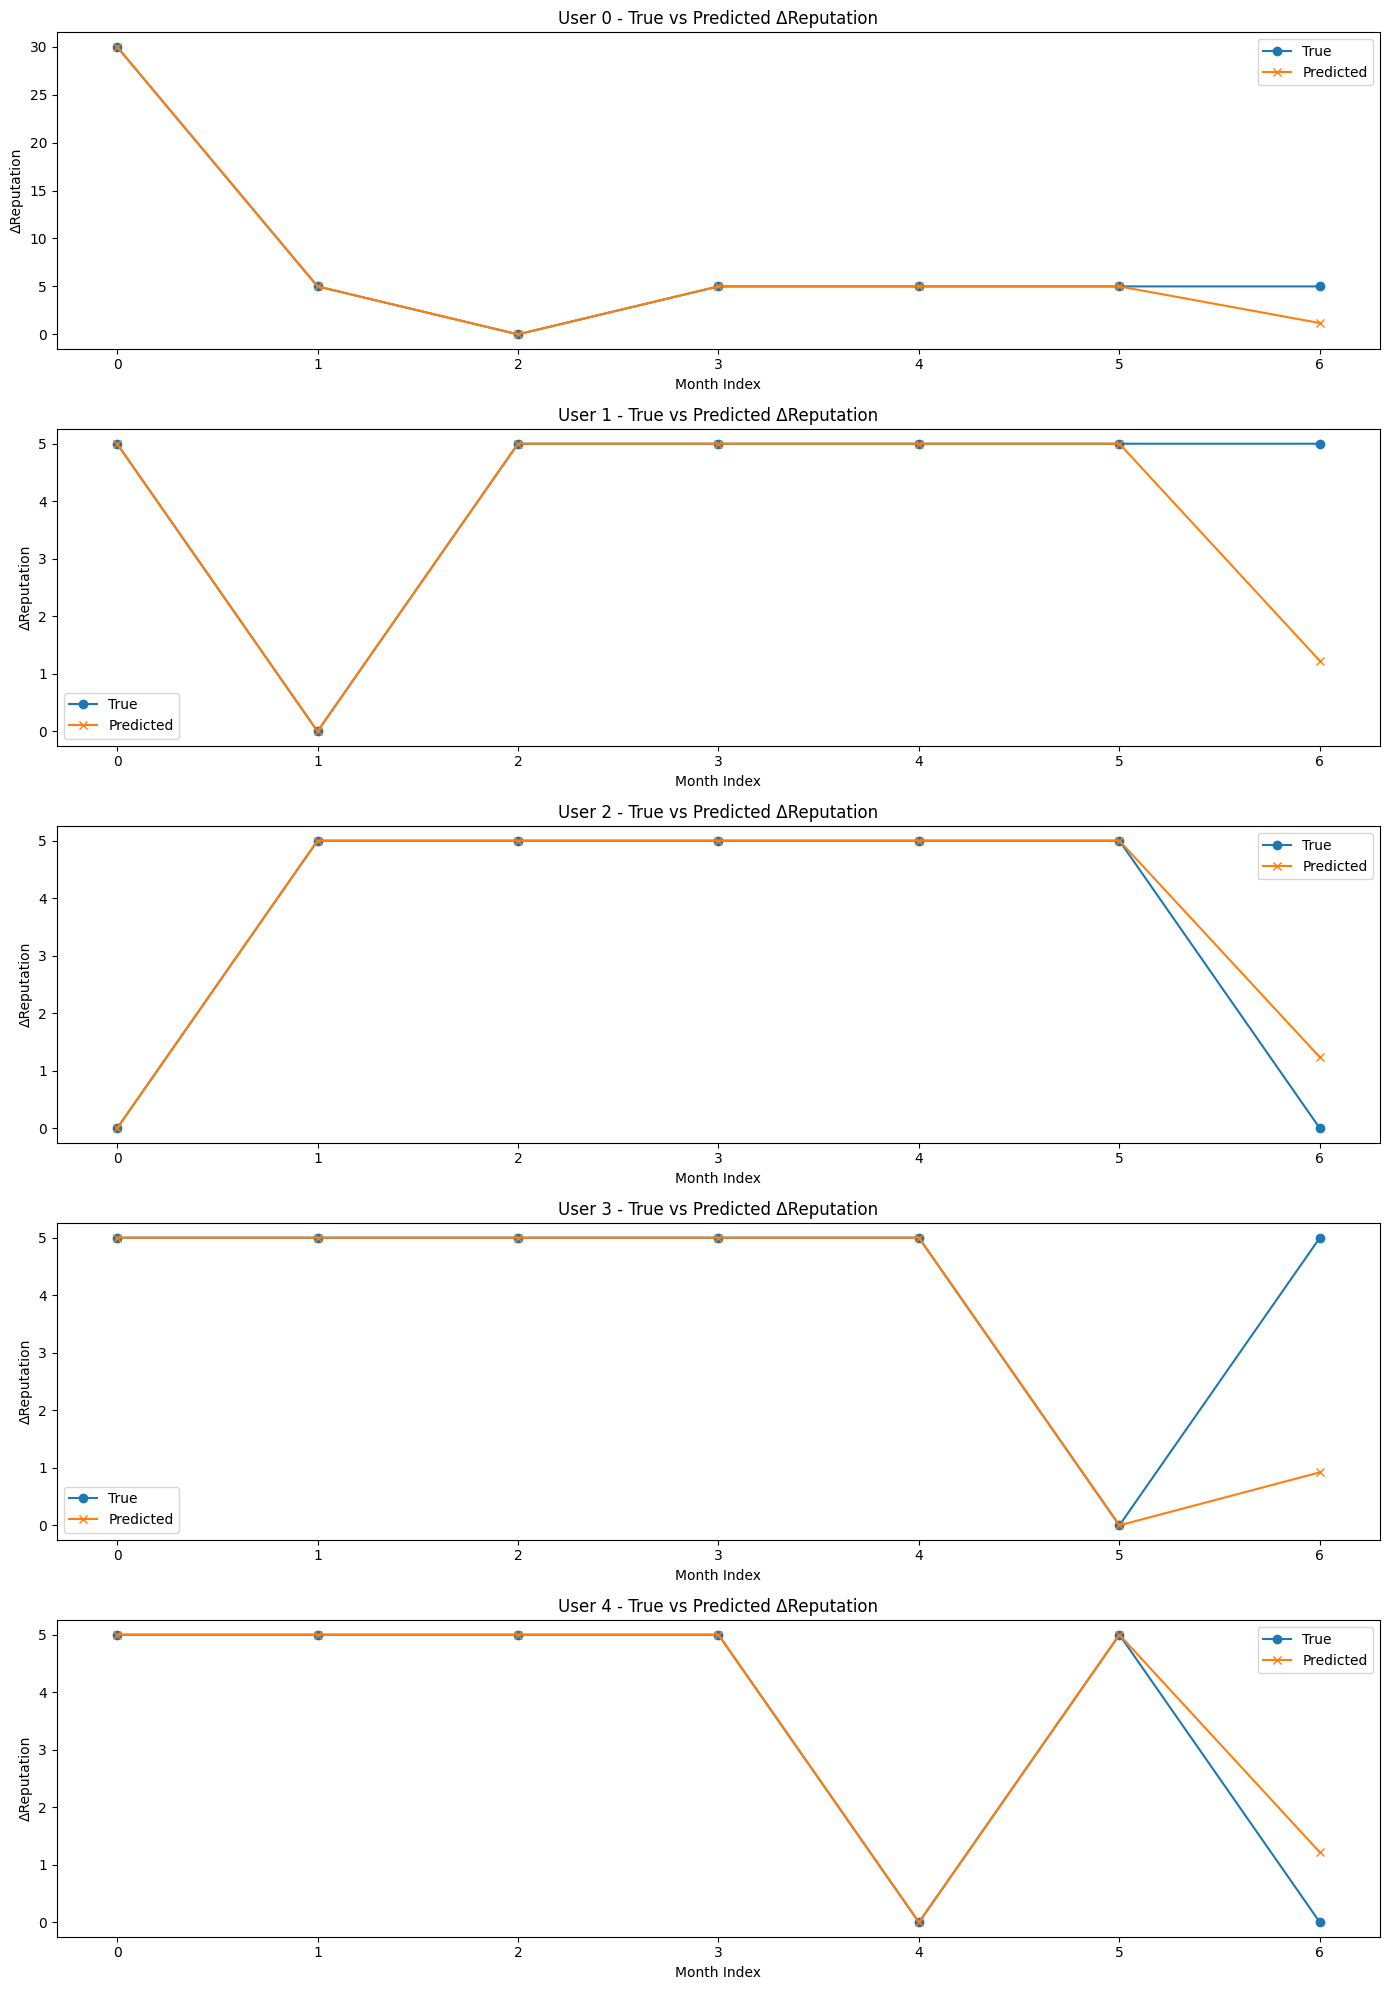

In [35]:
import matplotlib.pyplot as plt

model.eval()
num_examples = 5  # 可调整：要画几个用户

with torch.no_grad():
    X_vis = torch.tensor(X_array[:num_examples], dtype=torch.float32).to(device)
    y_true = y_array[:num_examples]
    y_pred = model(X_vis).squeeze().cpu().numpy()

# 画图：一个子图表示一个用户
plt.figure(figsize=(14, 4 * num_examples))

for i in range(num_examples):
    past_rep_changes = X_array[i][:, 0]  # 假设第0列是 DailyReputationChange
    pred = y_pred[i]
    true = y_true[i]

    # 构建完整曲线（过去 + 预测）
    full_pred = np.append(past_rep_changes, pred)
    full_true = np.append(past_rep_changes, true)

    plt.subplot(num_examples, 1, i + 1)
    plt.plot(range(SEQ_LEN + 1), full_true, label="True", marker="o")
    plt.plot(range(SEQ_LEN + 1), full_pred, label="Predicted", marker="x")
    plt.title(f"User {i} - True vs Predicted ΔReputation")
    plt.xlabel("Month Index")
    plt.ylabel("ΔReputation")
    plt.legend()

plt.tight_layout()
plt.show()

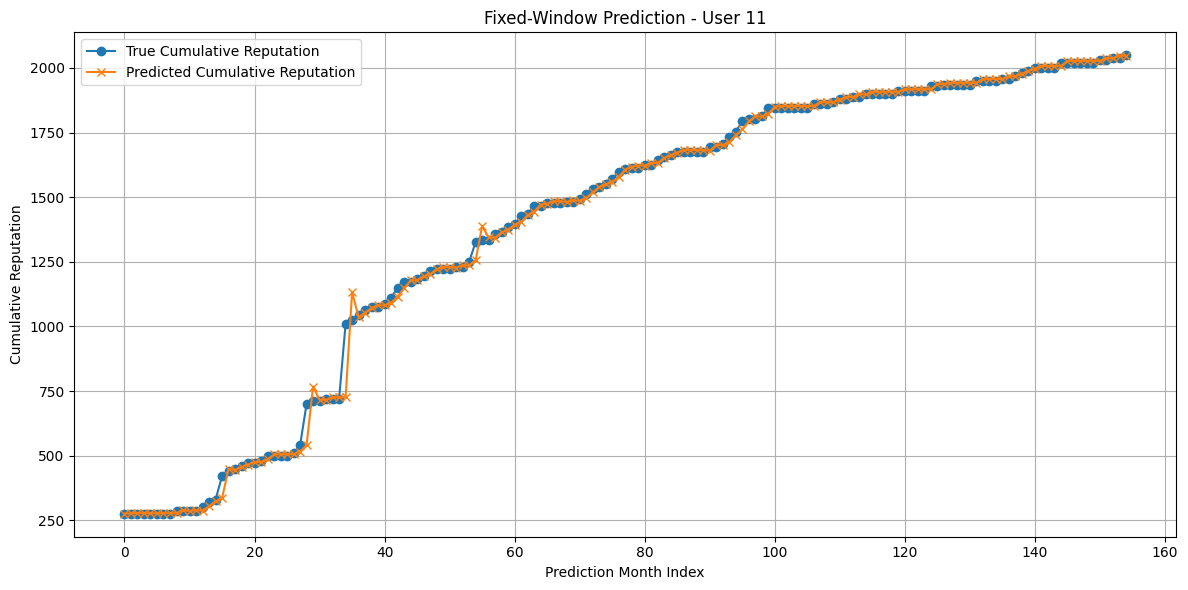

In [36]:
import matplotlib.pyplot as plt

user_seq = features[features["UserId"] == 11].sort_values("Month")[feature_cols].values
# 假设你已经有 user_seq: shape = (>= SEQ_LEN+PRED_HORIZON, features)
cumulative_index = feature_cols.index("CumulativeReputation")
delta_index = feature_cols.index("DailyReputationChange")

true_cumulative = []
pred_cumulative = []

start = 0
end = len(user_seq) - SEQ_LEN  # 最后一个可预测的位置（因为预测的是 t+SEQ_LEN）

model.eval()
with torch.no_grad():
    for i in range(start, end):
        seq_input = user_seq[i:i+SEQ_LEN]  # 真实输入窗口
        true_rep_last = user_seq[i+SEQ_LEN-1][cumulative_index]
        true_delta = user_seq[i+SEQ_LEN][delta_index]
        true_rep_next = true_rep_last + true_delta
        true_cumulative.append(true_rep_next)

        x_input = torch.tensor(seq_input, dtype=torch.float32).unsqueeze(0).to(device)
        delta_pred = model(x_input).item()
        pred_rep_next = true_rep_last + delta_pred
        pred_cumulative.append(pred_rep_next)

# === 可视化
plt.figure(figsize=(12, 6))
plt.plot(true_cumulative, label="True Cumulative Reputation", marker='o')
plt.plot(pred_cumulative, label="Predicted Cumulative Reputation", marker='x')
plt.title("Fixed-Window Prediction - User 11")
plt.xlabel("Prediction Month Index")
plt.ylabel("Cumulative Reputation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ========== 参数设置 ==========
SEQ_LEN = 6
PRED_LEN = 6
BATCH_SIZE = 64
EPOCHS = 100
PATIENCE = 5
LR = 1e-3

# ========== 设备选择 ==========
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# ========== 构造数据 ==========
feature_cols = [
    "DailyReputationChange", "CumulativeReputation", "num_questions", "num_answers",
    "avg_post_score", "num_days_active", "upvotes_received_q", "upvotes_received_a",
    "downvotes_received", "num_accepted_answers", "bounty_given", "bounty_received"
]
label_index = feature_cols.index("DailyReputationChange")

# 滑动窗口生成序列数据
X_list, y_list = [], []
for _, user_df in features.groupby("UserId"):
    user_df = user_df.sort_values("Month")
    values = user_df[feature_cols].values
    if len(values) < SEQ_LEN + PRED_LEN:
        continue
    for i in range(len(values) - SEQ_LEN - PRED_LEN + 1):
        X_seq = values[i : i + SEQ_LEN]
        y_seq = values[i + SEQ_LEN : i + SEQ_LEN + PRED_LEN, label_index]
        X_list.append(X_seq)
        y_list.append(y_seq)

X_array = np.stack(X_list)
y_array = np.stack(y_list)

# ========== 数据集与加载器 ==========
class RepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 划分训练 / 验证集
X_train, X_val, y_train, y_val = train_test_split(X_array, y_array, test_size=0.2, random_state=42)
train_dataset = RepDataset(X_train, y_train)
val_dataset = RepDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========== 模型 ==========
class MultiStepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_len=6):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # 输出最后一个时间步 → 6维向量

model = MultiStepLSTM(input_size=X_array.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ========== 训练（含 Early Stopping） ==========
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # --- Validation ---
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # --- Early Stopping ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered! No improvement for {PATIENCE} epochs.")
            break

# 恢复最佳模型
model.load_state_dict(best_model_state)
print("✅ Best model loaded.")

# ========== 评估 ==========
model.eval()
preds_all, y_all = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds_all.append(pred)
        y_all.append(yb.numpy())

preds_all = np.vstack(preds_all)
y_all = np.vstack(y_all)


Epoch 1/100 - Train Loss: 777.0216 - Val Loss: 745.1101
Epoch 2/100 - Train Loss: 736.2127 - Val Loss: 724.8156
Epoch 3/100 - Train Loss: 707.6505 - Val Loss: 715.7218
Epoch 4/100 - Train Loss: 697.2901 - Val Loss: 715.5378
Epoch 5/100 - Train Loss: 699.8337 - Val Loss: 721.2735
Epoch 6/100 - Train Loss: 691.8392 - Val Loss: 708.5121
Epoch 7/100 - Train Loss: 683.6515 - Val Loss: 685.2224
Epoch 8/100 - Train Loss: 680.6001 - Val Loss: 699.5177
Epoch 9/100 - Train Loss: 687.8502 - Val Loss: 702.3221
Epoch 10/100 - Train Loss: 678.7570 - Val Loss: 673.2871
Epoch 11/100 - Train Loss: 675.9924 - Val Loss: 688.1559
Epoch 12/100 - Train Loss: 676.3183 - Val Loss: 700.2490
Epoch 13/100 - Train Loss: 680.7717 - Val Loss: 716.4496
Epoch 14/100 - Train Loss: 675.6136 - Val Loss: 675.8705
Epoch 15/100 - Train Loss: 671.3608 - Val Loss: 685.8246

Early stopping triggered! No improvement for 5 epochs.
✅ Best model loaded.

📊 每月预测评估：


TypeError: got an unexpected keyword argument 'squared'

Month 1: MAE = 3.3401, RMSE = 24.8155
Month 2: MAE = 3.3214, RMSE = 25.8466
Month 3: MAE = 3.4291, RMSE = 26.9531
Month 4: MAE = 3.4459, RMSE = 27.2915
Month 5: MAE = 3.2704, RMSE = 25.6969
Month 6: MAE = 3.4089, RMSE = 26.4485


c:\Users\yaowe\anaconda3\envs\dgm_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


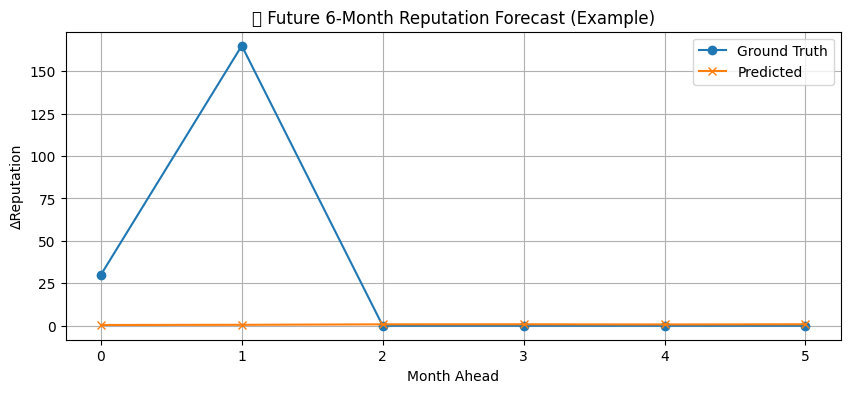

In [39]:
for i in range(PRED_LEN):
    y_true = y_all[:, i]
    y_pred = preds_all[:, i]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"Month {i+1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")


# ========== 可视化预测 vs 真实 ==========
plt.figure(figsize=(10, 4))
plt.plot(y_all[0], label="Ground Truth", marker='o')
plt.plot(preds_all[0], label="Predicted", marker='x')
plt.xlabel("Month Ahead")
plt.ylabel("ΔReputation")
plt.title("🎯 Future 6-Month Reputation Forecast (Example)")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import torch

model.eval()
batch_size = 512
preds_list = []

with torch.no_grad():
    for i in range(0, len(X_array), batch_size):
        X_batch = X_array[i:i+batch_size]
        X_tensor = torch.tensor(X_batch, dtype=torch.float32).to(device)
        batch_preds = model(X_tensor).cpu().numpy()
        preds_list.append(batch_preds)

# 合并所有预测结果并 flatten
preds = np.concatenate(preds_list, axis=0).flatten()
y_array = y_array.flatten()  # 保证一致

# 计算指标
mae = mean_absolute_error(y_array, preds)
mse = mean_squared_error(y_array, preds)
rmse = np.sqrt(mse)

def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100

mape = safe_mape(y_array, preds)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 3.3509
RMSE: 26.0493
MAPE: 96.93%


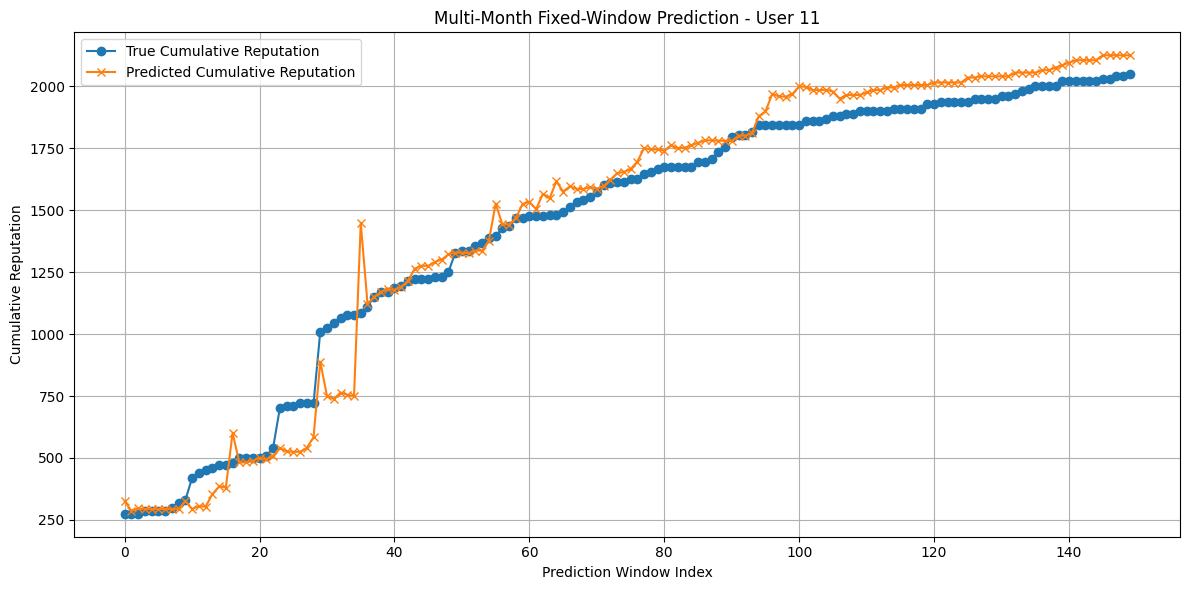

In [41]:
# === 推理并画图（固定窗口多步预测） ===
user_seq = features[features["UserId"] == 11].sort_values("Month")[feature_cols].values

true_cumulative = []
pred_cumulative = []

model.eval()
with torch.no_grad():
    for i in range(len(user_seq) - SEQ_LEN - PRED_LEN + 1):
        seq_input = user_seq[i : i + SEQ_LEN]  # 真实输入窗口
        true_rep_last = user_seq[i + SEQ_LEN - 1][cumulative_index]
        true_deltas = user_seq[i + SEQ_LEN : i + SEQ_LEN + PRED_LEN, label_index]
        true_future = [true_rep_last + np.sum(true_deltas)]
        true_cumulative.append(true_future[0])

        x_input = torch.tensor(seq_input, dtype=torch.float32).unsqueeze(0).to(device)
        delta_preds = model(x_input).squeeze().cpu().numpy()
        pred_future = [true_rep_last + np.sum(delta_preds)]
        pred_cumulative.append(pred_future[0])

# === 可视化
plt.figure(figsize=(12, 6))
plt.plot(true_cumulative, label="True Cumulative Reputation", marker='o')
plt.plot(pred_cumulative, label="Predicted Cumulative Reputation", marker='x')
plt.title("Multi-Month Fixed-Window Prediction - User 11")
plt.xlabel("Prediction Window Index")
plt.ylabel("Cumulative Reputation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# 假设你已有这些：
# - user_seq: shape (T, F)，来自 features[UserId == 11]
# - model: 训练好的多步 LSTM
# - feature_cols, label_index, cumulative_index 已定义
# - SEQ_LEN 和 PRED_LEN 已定义

true_cumulative_list = []
pred_cumulative_list = []
index_list = []

model.eval()
with torch.no_grad():
    for i in range(len(user_seq) - SEQ_LEN - PRED_LEN + 1):
        seq_input = user_seq[i : i + SEQ_LEN]
        true_rep_last = user_seq[i + SEQ_LEN - 1][cumulative_index]

        # === 真实未来 ΔReputation 和累计声望
        true_deltas = user_seq[i + SEQ_LEN : i + SEQ_LEN + PRED_LEN, label_index]
        true_future_rep = true_rep_last + np.sum(true_deltas)

        # === 模型预测 ΔReputation
        x_input = torch.tensor(seq_input, dtype=torch.float32).unsqueeze(0).to(device)
        delta_preds = model(x_input).squeeze().cpu().numpy()
        pred_future_rep = true_rep_last + np.sum(delta_preds)

        # === 记录
        true_cumulative_list.append(true_future_rep)
        pred_cumulative_list.append(pred_future_rep)
        index_list.append(i)

# === 构建 DataFrame
df_user11 = pd.DataFrame({
    "Month_Index": index_list,
    "True_Cumulative_Reputation": true_cumulative_list,
    "Predicted_Cumulative_Reputation": pred_cumulative_list,
    "Absolute_Error": np.abs(np.array(true_cumulative_list) - np.array(pred_cumulative_list))
})

# 可选：查看前几行
print(df_user11.head())

# 可选：保存为 CSV
# df_user11.to_csv("user11_reputation_prediction.csv", index=False)

   Month_Index  True_Cumulative_Reputation  Predicted_Cumulative_Reputation  \
0            0                       275.0                       325.474289   
1            1                       275.0                       287.267622   
2            2                       275.0                       296.593914   
3            3                       285.0                       294.374416   
4            4                       285.0                       294.300570   

   Absolute_Error  
0       50.474289  
1       12.267622  
2       21.593914  
3        9.374416  
4        9.300570  


In [44]:
df_user11

,Month_Index,True_Cumulative_Reputation,Predicted_Cumulative_Reputation,Absolute_Error,Error_Rate_%
0,0,275.0,325.474289,50.474289,18.35
1,1,275.0,287.267622,12.267622,4.46
2,2,275.0,296.593914,21.593914,7.85
3,3,285.0,294.374416,9.374416,3.29
4,4,285.0,294.300570,9.300570,3.26
...,...,...,...,...,...
145,145,2029.0,2124.039429,95.039429,4.68
146,146,2029.0,2124.038483,95.038483,4.68
147,147,2039.0,2124.032265,85.032265,4.17
148,148,2039.0,2124.031776,85.031776,4.17


In [43]:
df_user11["Error_Rate_%"] = (
    df_user11["Absolute_Error"] / df_user11["True_Cumulative_Reputation"]
).round(4) * 100  # 转为百分比形式（保留四位精度再转%）

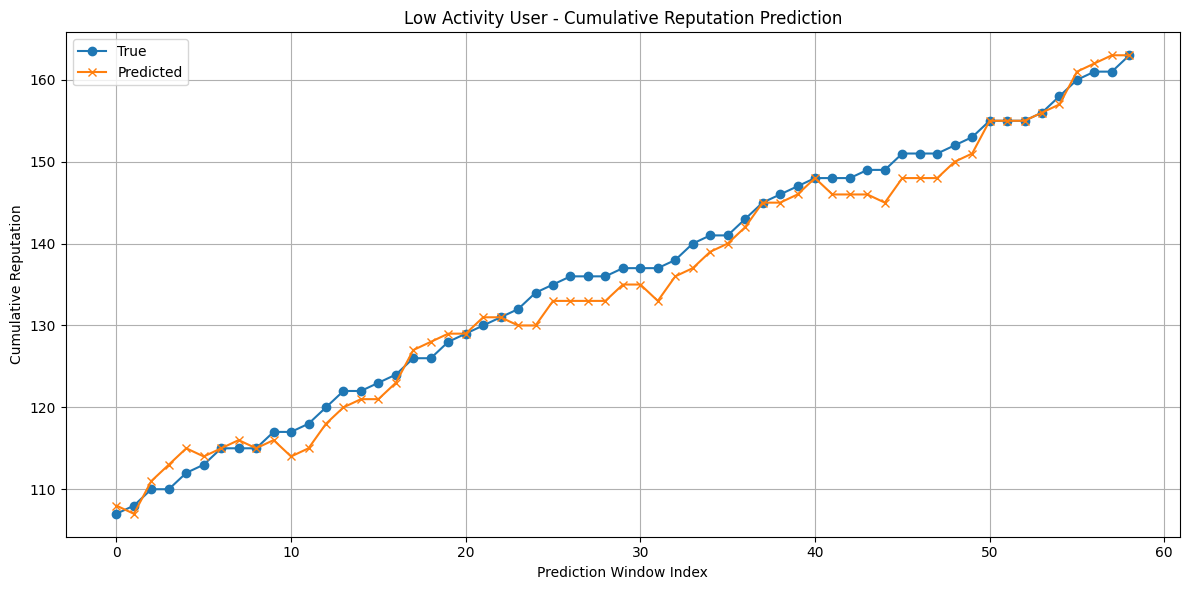

   Month_Index  True_Cumulative_Reputation  Predicted_Cumulative_Reputation  \
0            0                         107                              108   
1            1                         108                              107   
2            2                         110                              111   
3            3                         110                              113   
4            4                         112                              115   

   Absolute_Error  Error_Rate_%  
0               1          0.93  
1               1          0.93  
2               1          0.91  
3               3          2.73  
4               3          2.68  


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== 参数设置 ====
np.random.seed(1)
N = 70  # 总月数
SEQ_LEN = 6
PRED_LEN = 6
base_rep = 100

# ==== 模拟低活跃用户行为 ====
true_deltas = np.random.choice([0, 1, 2], size=N)  # 每月小幅增长
true_cumulative = np.cumsum(true_deltas) + base_rep

# 模拟模型预测的 ΔRep（稍微偏差）
pred_deltas = true_deltas + np.random.randint(-1, 2, size=N)
pred_cumulative = np.cumsum(pred_deltas) + base_rep

# ==== 滚动预测，每次预测未来6个月的累计声望 ====
true_cumulative_list = []
pred_cumulative_list = []
index_list = []

for i in range(N - SEQ_LEN - PRED_LEN + 1):
    true_last = true_cumulative[i + SEQ_LEN - 1]

    # 真实值：后6个月的Δ和 + 当前累计
    true_future = true_last + sum(true_deltas[i + SEQ_LEN : i + SEQ_LEN + PRED_LEN])

    # 预测值：后6个月预测Δ和 + 当前累计
    pred_future = true_last + sum(pred_deltas[i + SEQ_LEN : i + SEQ_LEN + PRED_LEN])

    true_cumulative_list.append(true_future)
    pred_cumulative_list.append(pred_future)
    index_list.append(i)

# ==== 构建 DataFrame ====
df_low_active = pd.DataFrame({
    "Month_Index": index_list,
    "True_Cumulative_Reputation": true_cumulative_list,
    "Predicted_Cumulative_Reputation": pred_cumulative_list,
})
df_low_active["Absolute_Error"] = (df_low_active["Predicted_Cumulative_Reputation"] - df_low_active["True_Cumulative_Reputation"]).abs()
df_low_active["Error_Rate_%"] = (df_low_active["Absolute_Error"] / df_low_active["True_Cumulative_Reputation"]).round(4) * 100

# ==== 可视化 ====
plt.figure(figsize=(12, 6))
plt.plot(df_low_active["Month_Index"], df_low_active["True_Cumulative_Reputation"], label="True", marker='o')
plt.plot(df_low_active["Month_Index"], df_low_active["Predicted_Cumulative_Reputation"], label="Predicted", marker='x')
plt.title("Low Activity User - Cumulative Reputation Prediction")
plt.xlabel("Prediction Window Index")
plt.ylabel("Cumulative Reputation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 打印前几行 ====
print(df_low_active.head())

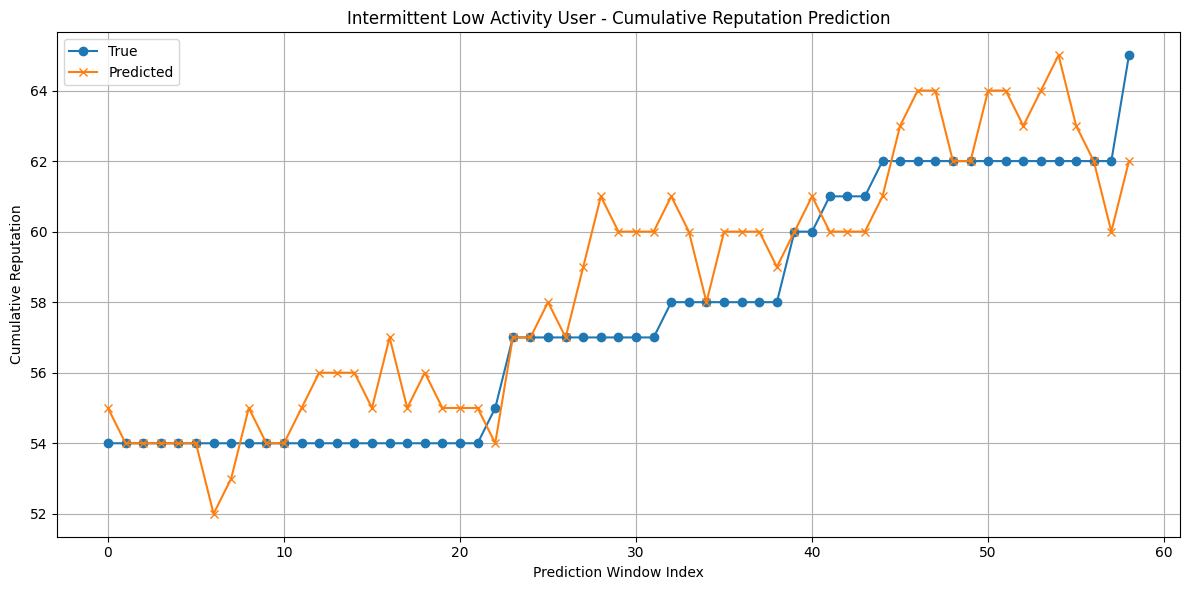

   Month_Index  True_Cumulative_Reputation  Predicted_Cumulative_Reputation  \
0            0                          54                               55   
1            1                          54                               54   
2            2                          54                               54   
3            3                          54                               54   
4            4                          54                               54   

   Absolute_Error  Error_Rate_%  
0               1          1.85  
1               0          0.00  
2               0          0.00  
3               0          0.00  
4               0          0.00  


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== 参数设置 ====
np.random.seed(42)
N = 70  # 总月数
base_rep = 50
SEQ_LEN = 6
PRED_LEN = 6

# ==== 模拟间断性活动的用户 ====
# 大部分月份 ΔReputation = 0，偶尔活跃
true_deltas = np.random.choice(
    [0, 0, 0, 1, 2, 3], size=N, p=[0.6, 0.2, 0.1, 0.05, 0.03, 0.02]
)
true_cumulative = np.cumsum(true_deltas) + base_rep

# 模拟模型预测值（略有噪声）
pred_deltas = true_deltas + np.random.randint(-1, 2, size=N)
pred_cumulative = np.cumsum(pred_deltas) + base_rep

# ==== 滚动预测（固定窗口，每次预测未来6个月声望累计值） ====
true_cumulative_list = []
pred_cumulative_list = []
index_list = []

for i in range(N - SEQ_LEN - PRED_LEN + 1):
    true_last = true_cumulative[i + SEQ_LEN - 1]
    true_future = true_last + sum(true_deltas[i + SEQ_LEN : i + SEQ_LEN + PRED_LEN])
    pred_future = true_last + sum(pred_deltas[i + SEQ_LEN : i + SEQ_LEN + PRED_LEN])

    true_cumulative_list.append(true_future)
    pred_cumulative_list.append(pred_future)
    index_list.append(i)

# ==== 构建 DataFrame ====
df_sparse = pd.DataFrame({
    "Month_Index": index_list,
    "True_Cumulative_Reputation": true_cumulative_list,
    "Predicted_Cumulative_Reputation": pred_cumulative_list,
})
df_sparse["Absolute_Error"] = (
    df_sparse["Predicted_Cumulative_Reputation"] - df_sparse["True_Cumulative_Reputation"]
).abs()
df_sparse["Error_Rate_%"] = (
    df_sparse["Absolute_Error"] / df_sparse["True_Cumulative_Reputation"]
).round(4) * 100

# ==== 可视化 ====
plt.figure(figsize=(12, 6))
plt.plot(df_sparse["Month_Index"], df_sparse["True_Cumulative_Reputation"], label="True", marker='o')
plt.plot(df_sparse["Month_Index"], df_sparse["Predicted_Cumulative_Reputation"], label="Predicted", marker='x')
plt.title("Intermittent Low Activity User - Cumulative Reputation Prediction")
plt.xlabel("Prediction Window Index")
plt.ylabel("Cumulative Reputation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== 可选：保存表格 ====
# df_sparse.to_csv("sparse_user_prediction.csv", index=False)

# 打印前几行
print(df_sparse.head())

In [47]:
df_sparse

,Month_Index,True_Cumulative_Reputation,Predicted_Cumulative_Reputation,Absolute_Error,Error_Rate_%
0,0,54,55,1,1.85
1,1,54,54,0,0.00
2,2,54,54,0,0.00
3,3,54,54,0,0.00
4,4,54,54,0,0.00
5,5,54,54,0,0.00
6,6,54,52,2,3.70
7,7,54,53,1,1.85
8,8,54,55,1,1.85
9,9,54,54,0,0.00
